In [80]:
import numpy as np
import torch

from env import Env
from model_dqn import QNet
from utils import generate_actions
import matplotlib.pyplot as plt

In [81]:
action_list = generate_actions()

env = Env()

model = QNet(n_actions=len(action_list),n_observations=6)
model.load_state_dict(torch.load("../results-train/Q_model_FINAL_cpu.dump"))
model.eval()


QNet(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=21, bias=True)
  (act): ReLU()
)

In [82]:
env.total_ru_services

[[4, 1, 0],
 [3, 1, 1],
 [2, 1, 2],
 [0, 1, 4],
 [1, 1, 3],
 [0, 0, 5],
 [2, 2, 1],
 [3, 2, 0]]

In [83]:
env.reset()
state = env.get_state()

cumulative_rewards = 0
actions = []
bands = []
energy = []
for time in range(8):
    bands.append(state[:3])
    energy.append(env.energy_consumption)
    with torch.no_grad():
        X = torch.tensor(state).unsqueeze(0).to(torch.float)
        action_q_values = model(X).numpy().squeeze()
    
    action = int(np.argmax(action_q_values, axis=0))
    next_state, reward = env.processing(time, action_list[action])

    state = next_state

    if reward < 0:
        break

    actions.append(action_list[action])
    cumulative_rewards += reward
bands.append(env.get_state(7)[:3])
energy.append(env.energy_consumption)




In [84]:
print(actions)
print(bands)
print(energy)
print(env.total_ru_services)

[[5, 0, 0], [4, 0, 1], [2, 1, 2], [0, 0, 5], [1, 0, 4], [0, 0, 5], [4, 0, 1], [2, 3, 0]]
[[0, 0, 0], [9830, 0, 0], [17768, 1892, 0], [22522.4, 6967.6, 0], [22892.4, 16427.6, 0], [25154.4, 18319.6, 5676], [25524.4, 18319.6, 15136], [33462.4, 18319.6, 17028], [39417.600000000006, 19611.199999999997, 19611.199999999997]]
[0, 600, 900, 900, 900, 1200, 1200, 1200, 1200]
[[4, 1, 0], [3, 1, 1], [2, 1, 2], [0, 1, 4], [1, 1, 3], [0, 0, 5], [2, 2, 1], [3, 2, 0]]


In [133]:
############ PARTES DAS MÉTRICAS ###########3

# Capcidade vpon e ativção de Linecards
vpon_cost = 20
energy_per_vpon = 10000 * vpon_cost

###############################################
# Convertendo para arrays numpy
bands_array = np.array(bands)
time_steps = np.arange(1, len(bands_array))  # Começa em 1 para corresponder ao ajuste em cloud_band
#time_steps = time_steps[1:]
print(time_steps)
#time_steps = time_steps
action_array = np.array(actions)
cloud_band = bands_array[:, 0]
fogs_sum = np.sum(bands_array[:, 1:], axis=1)
ru_sum = np.sum(action_array[:], axis=1)
#print(ru_sum)
###############################################


# Calculando a quantidade de VPONs para cada tempo
vpon_counts = np.floor(cloud_band / 10000) + np.floor(fogs_sum / 10000)

vpon_energy = vpon_counts * energy_per_vpon

# Calculando a energia total em cada passo de tempo
total_energy = energy + vpon_energy

# Número total de nós
num_nodes = 3

# Capacidade de cada VPON
vpon_capacity = 10000

# Calculando o Total activated RU (soma dos valores internos em cada array)
total_activated_ru = np.sum(bands_array, axis=1)
total_activated_ru = total_activated_ru[1:]

# Multiplicando o tráfego RU por 1966 para cada passo de tempo
traffic_ru = total_activated_ru * 1966

# Calculando o Total RU bands (Total activated RU * 1966) - CBR
total_ru_bands = total_activated_ru * 1966
#print(total_activated_ru)

# Convertendo para arrays numpy
bands_array = np.array(bands)
time_steps = np.arange(len(bands_array))

# Separando a primeira banda (cloud) e as outras bandas (fogs)
cloud_band = bands_array[:, 0]
cloud_band = cloud_band[1:]
fogs_sum = np.sum(bands_array[:, 1:], axis=1)
fogs_sum = fogs_sum[1:]
print(fogs_sum)


# Total de banda gerado em cada passo de tempo
total_band_generated = cloud_band + fogs_sum

# Total de VPONs ativadas em cada passo de tempo
total_vpons_activated = np.ceil(total_band_generated / vpon_capacity)
#print(total_vpons_activated)

# Eficiência da ativação das VPONs em porcentagem
#TODO: Não parece bom
efficiency_percentage = (((total_vpons_activated *1000)/total_band_generated)-100)*-1
print(efficiency_percentage)

#Disponibilidade do sistema
availability = total_ru_bands/(fogs_sum+cloud_band)
availability_percentage = availability * 100


[1 2 3 4 5 6 7 8]
[    0.   1892.   6967.6 16427.6 23995.6 33455.6 35347.6 39222.4]
[99.8982706 99.8982706 99.8982706 99.8982706 99.8982706 99.8982706
 99.8982706 99.8982706]


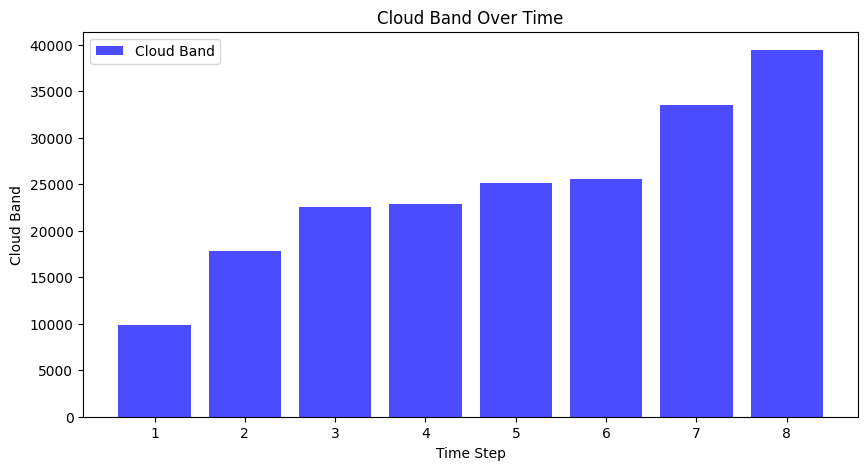

In [113]:



# banda cloud
plt.figure(figsize=(10, 5))
plt.bar(time_steps[1:], cloud_band, label='Cloud Band', color='blue', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Cloud Band')
plt.title('Cloud Band Over Time')
plt.legend()
plt.show()



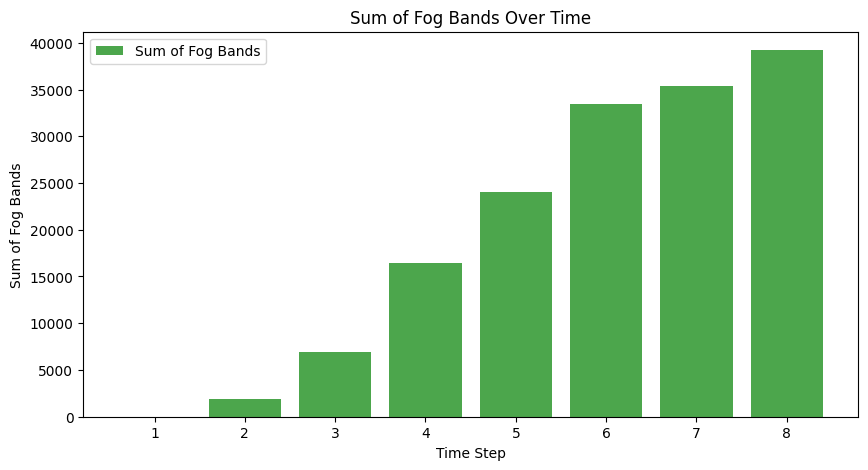

In [115]:
# soma das bandas fogs
plt.figure(figsize=(10, 5))
plt.bar(time_steps[1:], fogs_sum, label='Sum of Fog Bands', color='green', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Sum of Fog Bands')
plt.title('Sum of Fog Bands Over Time')
plt.legend()
plt.show()



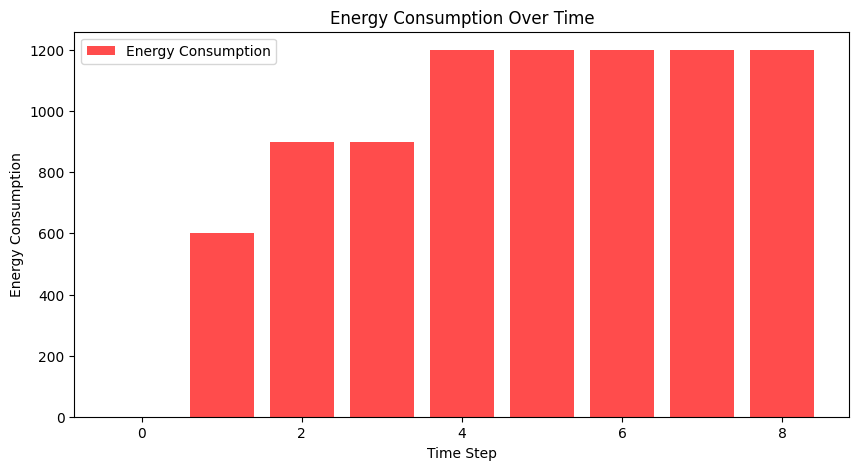

In [52]:
# energia sem as vpons
plt.figure(figsize=(10, 5))
plt.bar(time_steps[1:], energy, label='Energy Consumption', color='red', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.show()


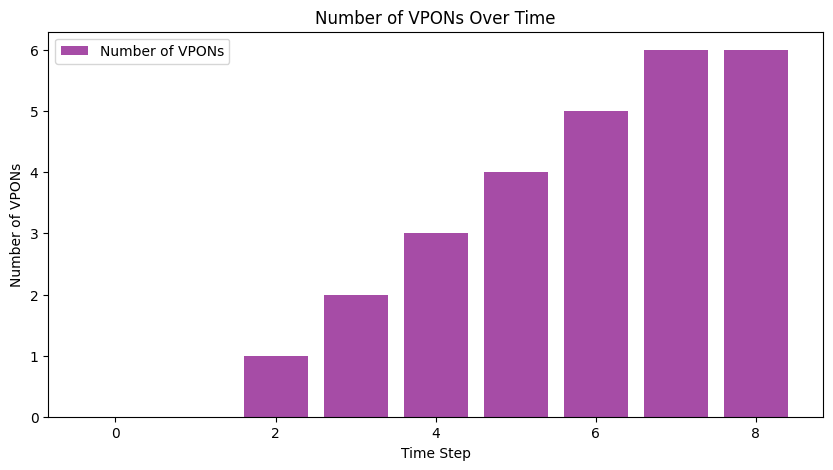

In [53]:

# quantidade de VPONs Ativas
plt.figure(figsize=(10, 5))
plt.bar(time_steps[1:], vpon_counts, label='Number of VPONs', color='purple', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Number of VPONs')
plt.title('Number of VPONs Over Time')
plt.legend()
plt.show()



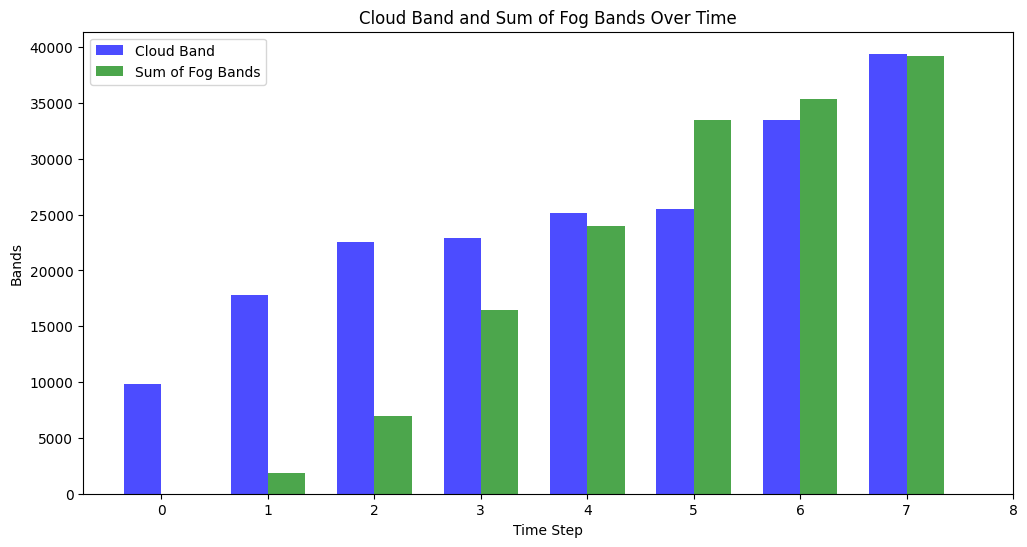

In [117]:
# tráfeogo total = banda da cloud com a soma das bandas das fogs
bar_width = 0.35
r1 = np.arange(len(time_steps[1:]))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, cloud_band, width=bar_width, label='Cloud Band', color='blue', alpha=0.7)
plt.bar(r2, fogs_sum, width=bar_width, label='Sum of Fog Bands', color='green', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Bands')
plt.title('Cloud Band and Sum of Fog Bands Over Time')
plt.xticks([r + bar_width/2 for r in range(len(time_steps))], time_steps)
plt.legend()
plt.show()



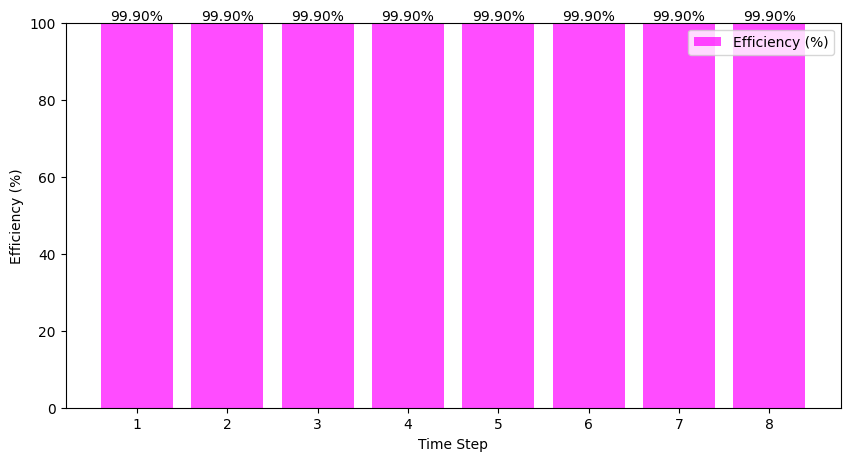

In [132]:
# eficiência da ativação das VPONs/ vpons por tráfego gerado
plt.figure(figsize=(10, 5))
bars = plt.bar(time_steps[1:], efficiency_percentage, label='Efficiency (%)', color='magenta', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Efficiency (%)')
#plt.title('Efficiency of VPON Activation Over Time')
plt.ylim(0, 100)  # Definindo o limite do eixo y de 0 a 100%
plt.legend()

# Adicionando os valores das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}%", va='bottom', ha='center')

plt.show()


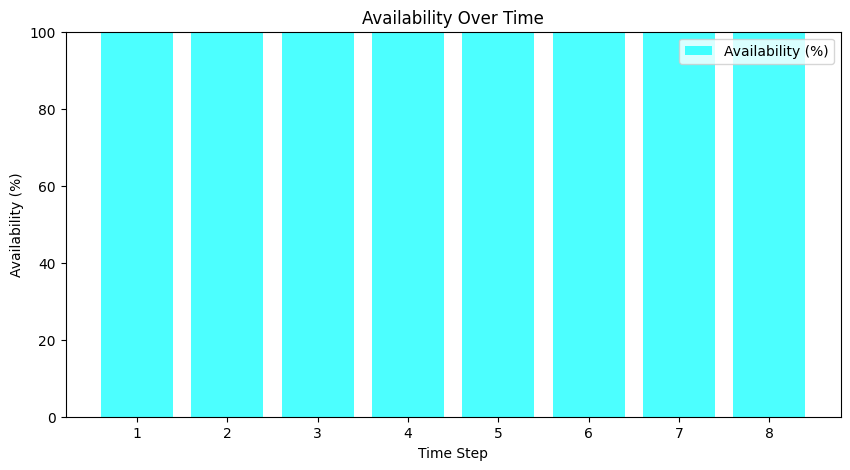

In [134]:
# disponibilidade em porcentagem
plt.figure(figsize=(10, 5))
plt.bar(time_steps[1:], availability_percentage, label='Availability (%)', color='cyan', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Availability (%)')
plt.title('Availability Over Time')
plt.ylim(0, 100)  # Definindo o limite do eixo y de 0 a 100%
plt.legend()
plt.show()